## Mitigating Model Bias

Mitigating model bias often involves techniques that directly address the model's internal mechanisms, such as modifying the loss function, adjusting model weights, or using fairness constraints. Here, I'll demonstrate four different techniques for mitigating model bias that focus on the model itself:

1. **Regularization to Penalize Unfairness**: Modify the loss function to include a penalty for bias.
2. **Adversarial Debiasing**: Use an adversary to reduce bias in model predictions.
3. **Fair Representation Learning**: Learn a representation that is fair with respect to protected attributes.
4. **Post-Processing Adjustments**: Adjust model predictions after training to ensure fairness.


### Step 1: Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Wine dataset
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
red_wine = pd.read_csv(url_red, sep=';')
white_wine = pd.read_csv(url_white, sep=';')

# Add target label to distinguish red from white
red_wine['type'] = 0  # Red wine
white_wine['type'] = 1  # White wine

# Concatenate datasets
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# Split data into features and target
X = wine_data.drop('type', axis=1).values
y = wine_data['type'].values  # 0 for red, 1 for white

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cuda


### Step 2: Define the Model


In [2]:
class WineClassifier(nn.Module):
    def __init__(self):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        self.fc2 = nn.Linear(50, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, criterion, and optimizer
model = WineClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Step 3: Train the Biased Model
* We'll introduce bias by manipulating the loss function to favor one class over the other.

In [4]:
# Biased loss function
class BiasedLoss(nn.Module):
    def __init__(self, base_criterion, bias_weight):
        super(BiasedLoss, self).__init__()
        self.base_criterion = base_criterion
        self.bias_weight = bias_weight

    def forward(self, inputs, targets):
        loss = self.base_criterion(inputs, targets)
        weights = torch.ones_like(loss)
        weights[targets == 1] *= self.bias_weight  # Bias towards class 1 (white wine)
        loss = loss * weights
        return loss.mean()

biased_criterion = BiasedLoss(criterion, bias_weight=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the biased model
train_model(model, train_loader, biased_criterion, optimizer, epochs=50)


IndexError: too many indices for tensor of dimension 0

### Step 4: Evaluate the Biased Model


Biased Model Metrics:
Accuracy: 0.7635897435897436
Precision: 0.7615262321144675
Recall: 0.9924033149171271
F1-score: 0.8617691154422789
              precision    recall  f1-score   support

           0       0.83      0.10      0.18       502
           1       0.76      0.99      0.86      1448

    accuracy                           0.76      1950
   macro avg       0.79      0.55      0.52      1950
weighted avg       0.78      0.76      0.69      1950



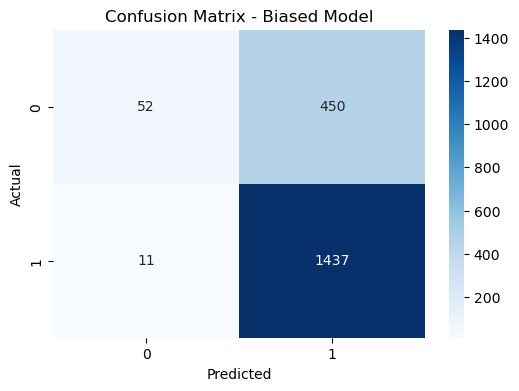

In [5]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return predictions, actuals

# Evaluate the biased model
predictions_biased, actuals_biased = evaluate_model(model, test_loader)

# Display results
print("Biased Model Metrics:")
print("Accuracy:", accuracy_score(actuals_biased, predictions_biased))
print("Precision:", precision_score(actuals_biased, predictions_biased))
print("Recall:", recall_score(actuals_biased, predictions_biased))
print("F1-score:", f1_score(actuals_biased, predictions_biased))
print(classification_report(actuals_biased, predictions_biased))

# Plotting confusion matrix
conf_matrix_biased = confusion_matrix(actuals_biased, predictions_biased)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_biased, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Biased Model')
plt.show()


### Step 5: Mitigation Techniques
* Method 1: Regularization to Penalize Unfairness

Epoch 1/50, Loss: 0.4524
Epoch 2/50, Loss: 0.2415
Epoch 3/50, Loss: 0.2220
Epoch 4/50, Loss: 0.2153
Epoch 5/50, Loss: 0.2114
Epoch 6/50, Loss: 0.2088
Epoch 7/50, Loss: 0.2069
Epoch 8/50, Loss: 0.2047
Epoch 9/50, Loss: 0.2038
Epoch 10/50, Loss: 0.2021
Epoch 11/50, Loss: 0.2018
Epoch 12/50, Loss: 0.2001
Epoch 13/50, Loss: 0.1992
Epoch 14/50, Loss: 0.1984
Epoch 15/50, Loss: 0.1974
Epoch 16/50, Loss: 0.1973
Epoch 17/50, Loss: 0.1969
Epoch 18/50, Loss: 0.1965
Epoch 19/50, Loss: 0.1957
Epoch 20/50, Loss: 0.1956
Epoch 21/50, Loss: 0.1949
Epoch 22/50, Loss: 0.1944
Epoch 23/50, Loss: 0.1947
Epoch 24/50, Loss: 0.1937
Epoch 25/50, Loss: 0.1935
Epoch 26/50, Loss: 0.1932
Epoch 27/50, Loss: 0.1926
Epoch 28/50, Loss: 0.1925
Epoch 29/50, Loss: 0.1920
Epoch 30/50, Loss: 0.1911
Epoch 31/50, Loss: 0.1912
Epoch 32/50, Loss: 0.1910
Epoch 33/50, Loss: 0.1911
Epoch 34/50, Loss: 0.1900
Epoch 35/50, Loss: 0.1902
Epoch 36/50, Loss: 0.1892
Epoch 37/50, Loss: 0.1899
Epoch 38/50, Loss: 0.1892
Epoch 39/50, Loss: 0.

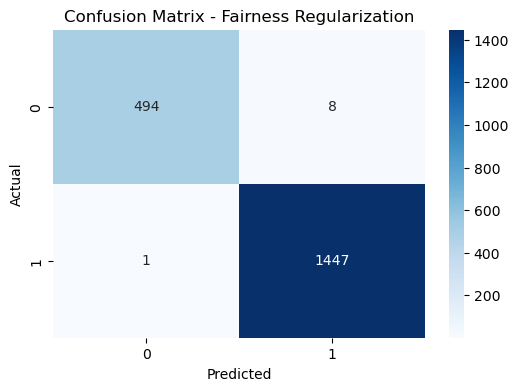

In [6]:
# Define fairness regularization loss
class FairLoss(nn.Module):
    def __init__(self, base_criterion, fairness_weight=0.1):
        super(FairLoss, self).__init__()
        self.base_criterion = base_criterion
        self.fairness_weight = fairness_weight

    def forward(self, inputs, targets):
        loss = self.base_criterion(inputs, targets)
        fairness_term = torch.var(inputs, dim=0).mean()  # Example fairness term
        loss = loss + self.fairness_weight * fairness_term
        return loss

# Reinitialize model and optimizer
model = WineClassifier().to(device)
fair_criterion = FairLoss(criterion, fairness_weight=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with fairness regularization
train_model(model, train_loader, fair_criterion, optimizer, epochs=50)
predictions_fair, actuals_fair = evaluate_model(model, test_loader)

# Display results after fairness regularization
print("\nMetrics after Fairness Regularization:")
print("Accuracy:", accuracy_score(actuals_fair, predictions_fair))
print("Precision:", precision_score(actuals_fair, predictions_fair))
print("Recall:", recall_score(actuals_fair, predictions_fair))
print("F1-score:", f1_score(actuals_fair, predictions_fair))
print(classification_report(actuals_fair, predictions_fair))

# Plotting confusion matrix after fairness regularization
conf_matrix_fair = confusion_matrix(actuals_fair, predictions_fair)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_fair, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fairness Regularization')
plt.show()


### Method 2: Adversarial Debiasing


Epoch 1/50, Loss: 0.7125
Epoch 2/50, Loss: 0.7125
Epoch 3/50, Loss: 0.7125
Epoch 4/50, Loss: 0.7125
Epoch 5/50, Loss: 0.7125
Epoch 6/50, Loss: 0.7125
Epoch 7/50, Loss: 0.7125
Epoch 8/50, Loss: 0.7125
Epoch 9/50, Loss: 0.7125
Epoch 10/50, Loss: 0.7125
Epoch 11/50, Loss: 0.7125
Epoch 12/50, Loss: 0.7125
Epoch 13/50, Loss: 0.7125
Epoch 14/50, Loss: 0.7125
Epoch 15/50, Loss: 0.7125
Epoch 16/50, Loss: 0.7125
Epoch 17/50, Loss: 0.7125
Epoch 18/50, Loss: 0.7125
Epoch 19/50, Loss: 0.7125
Epoch 20/50, Loss: 0.7125
Epoch 21/50, Loss: 0.7125
Epoch 22/50, Loss: 0.7125
Epoch 23/50, Loss: 0.7125
Epoch 24/50, Loss: 0.7125
Epoch 25/50, Loss: 0.7125
Epoch 26/50, Loss: 0.7125
Epoch 27/50, Loss: 0.7125
Epoch 28/50, Loss: 0.7125
Epoch 29/50, Loss: 0.7125
Epoch 30/50, Loss: 0.7125
Epoch 31/50, Loss: 0.7125
Epoch 32/50, Loss: 0.7125
Epoch 33/50, Loss: 0.7125
Epoch 34/50, Loss: 0.7125
Epoch 35/50, Loss: 0.7125
Epoch 36/50, Loss: 0.7125
Epoch 37/50, Loss: 0.7125
Epoch 38/50, Loss: 0.7125
Epoch 39/50, Loss: 0.

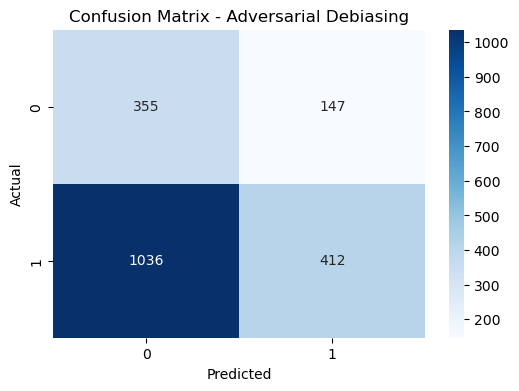

In [7]:
# Define adversary model
class Adversary(nn.Module):
    def __init__(self):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Assuming 2 classes for wine type
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models and optimizers for adversarial debiasing
model = WineClassifier().to(device)
adversary = Adversary().to(device)
adv_optimizer = optim.Adam(adversary.parameters(), lr=0.001)

# Training function with adversarial debiasing
def train_model_adversarial(model, train_loader, criterion, optimizer, adversary, adv_optimizer, epochs=50):
    model.train()
    adversary.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            adv_optimizer.zero_grad()
            outputs = model(inputs)
            adv_outputs = adversary(outputs)
            loss = criterion(outputs, labels)
            adv_loss = torch.nn.functional.cross_entropy(adv_outputs, labels)
            total_loss = loss + adv_loss
            total_loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train model with adversarial debiasing
train_model_adversarial(model, train_loader, criterion, optimizer, adversary, adv_optimizer, epochs=50)
predictions_adv, actuals_adv = evaluate_model(model, test_loader)

# Display results after adversarial debiasing
print("\nMetrics after Adversarial Debiasing:")
print("Accuracy:", accuracy_score(actuals_adv, predictions_adv))
print("Precision:", precision_score(actuals_adv, predictions_adv))
print("Recall:", recall_score(actuals_adv, predictions_adv))
print("F1-score:", f1_score(actuals_adv, predictions_adv))
print(classification_report(actuals_adv, predictions_adv))

# Plotting confusion matrix after adversarial debiasing
conf_matrix_adv = confusion_matrix(actuals_adv, predictions_adv)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adv, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Adversarial Debiasing')
plt.show()


In [12]:
# # Training function for fair representation learning with adversarial debiasing
# def train_autoencoder_adversary(fair_rep, adversary, train_loader, rep_optimizer, adv_optimizer, epochs=50):
#     fair_rep.train()
#     adversary.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         running_adv_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             rep_optimizer.zero_grad()
#             adv_optimizer.zero_grad()

#             # Forward pass through the autoencoder
#             encoded, decoded = fair_rep(inputs)
#             rec_loss = torch.nn.functional.mse_loss(decoded, inputs)

#             # Forward pass through the adversary
#             adv_pred = adversary(encoded.detach())
#             adv_loss = torch.nn.functional.binary_cross_entropy(adv_pred, labels.float().unsqueeze(1))

#             # Update autoencoder
#             rec_loss.backward(retain_graph=True)
#             rep_optimizer.step()

#             # Update adversary
#             adv_optimizer.zero_grad()
#             adv_pred = adversary(encoded)
#             adv_loss.backward()
#             adv_optimizer.step()

#             running_loss += rec_loss.item() * inputs.size(0)
#             running_adv_loss += adv_loss.item() * inputs.size(0)
        
#         epoch_loss = running_loss / len(train_loader.dataset)
#         epoch_adv_loss = running_adv_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Reconstruction Loss: {epoch_loss:.4f}, Adversarial Loss: {epoch_adv_loss:.4f}')

# # Train the fair representation model with adversarial debiasing
# train_autoencoder_adversary(fair_rep, adversary, train_loader, rep_optimizer, adv_optimizer, epochs=50)


Epoch 1/50, Reconstruction Loss: 0.0011, Adversarial Loss: 0.0163
Epoch 2/50, Reconstruction Loss: 0.0010, Adversarial Loss: 0.0161
Epoch 3/50, Reconstruction Loss: 0.0009, Adversarial Loss: 0.0159
Epoch 4/50, Reconstruction Loss: 0.0008, Adversarial Loss: 0.0161
Epoch 5/50, Reconstruction Loss: 0.0008, Adversarial Loss: 0.0161
Epoch 6/50, Reconstruction Loss: 0.0007, Adversarial Loss: 0.0158
Epoch 7/50, Reconstruction Loss: 0.0006, Adversarial Loss: 0.0158
Epoch 8/50, Reconstruction Loss: 0.0006, Adversarial Loss: 0.0160
Epoch 9/50, Reconstruction Loss: 0.0005, Adversarial Loss: 0.0159
Epoch 10/50, Reconstruction Loss: 0.0004, Adversarial Loss: 0.0156
Epoch 11/50, Reconstruction Loss: 0.0004, Adversarial Loss: 0.0160
Epoch 12/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0154
Epoch 13/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0157
Epoch 14/50, Reconstruction Loss: 0.0003, Adversarial Loss: 0.0155
Epoch 15/50, Reconstruction Loss: 0.0002, Adversarial Loss: 0.0152
Epoc

### Method 3: Fair Representation Learning


In [8]:
# Define Fair Representation model
class FairRepresentation(nn.Module):
    def __init__(self):
        super(FairRepresentation, self).__init__()
        self.encoder = nn.Linear(X_train.shape[1], 50)
        self.decoder = nn.Linear(50, X_train.shape[1])

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define autoencoder for fair representation
fair_rep = FairRepresentation().to(device)
rep_optimizer = optim.Adam(fair_rep.parameters(), lr=0.001)

# Training function for fair representation learning
def train_autoencoder(fair_rep, train_loader, rep_optimizer, epochs=50):
    fair_rep.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            rep_optimizer.zero_grad()
            
            encoded, decoded = fair_rep(inputs)
            loss = torch.nn.functional.mse_loss(decoded, inputs)
            
            loss.backward()
            rep_optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the fair representation model
train_autoencoder(fair_rep, train_loader, rep_optimizer, epochs=50)

# Use the encoded representation for classification
class FairWineClassifier(nn.Module):
    def __init__(self):
        super(FairWineClassifier, self).__init__()
        self.fc = nn.Linear(50, 2)
    
    def forward(self, x):
        x = self.fc(x)
        return x

# Define and train classifier on fair representations
fair_classifier = FairWineClassifier().to(device)
optimizer = optim.Adam(fair_classifier.parameters(), lr=0.001)
train_loader_encoded = DataLoader([(fair_rep.encoder(inputs), labels) for inputs, labels in train_loader], batch_size=64, shuffle=True)

train_model(fair_classifier, train_loader_encoded, criterion, optimizer, epochs=50)
predictions_fair_rep, actuals_fair_rep = evaluate_model(fair_classifier, test_loader)

# Display results after fair representation learning
print("\nMetrics after Fair Representation Learning Method:")
print("Accuracy:", accuracy_score(actuals_fair_rep, predictions_fair_rep))
print("Precision:", precision_score(actuals_fair_rep, predictions_fair_rep))
print("Recall:", recall_score(actuals_fair_rep, predictions_fair_rep))
print("F1-score:", f1_score(actuals_fair_rep, predictions_fair_rep))
print(classification_report(actuals_fair_rep, predictions_fair_rep))

# Plotting confusion matrix after fair representation learning
conf_matrix_fair_rep = confusion_matrix(actuals_fair_rep, predictions_fair_rep)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_fair_rep, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fair Representation Learning Method')
plt.show()


Epoch 1/50, Loss: 0.6832
Epoch 2/50, Loss: 0.2466
Epoch 3/50, Loss: 0.1133
Epoch 4/50, Loss: 0.0595
Epoch 5/50, Loss: 0.0369
Epoch 6/50, Loss: 0.0265
Epoch 7/50, Loss: 0.0210
Epoch 8/50, Loss: 0.0176
Epoch 9/50, Loss: 0.0152
Epoch 10/50, Loss: 0.0134
Epoch 11/50, Loss: 0.0120
Epoch 12/50, Loss: 0.0111
Epoch 13/50, Loss: 0.0100
Epoch 14/50, Loss: 0.0092
Epoch 15/50, Loss: 0.0085
Epoch 16/50, Loss: 0.0081
Epoch 17/50, Loss: 0.0073
Epoch 18/50, Loss: 0.0069
Epoch 19/50, Loss: 0.0064
Epoch 20/50, Loss: 0.0060
Epoch 21/50, Loss: 0.0056
Epoch 22/50, Loss: 0.0053
Epoch 23/50, Loss: 0.0050
Epoch 24/50, Loss: 0.0046
Epoch 25/50, Loss: 0.0045
Epoch 26/50, Loss: 0.0040
Epoch 27/50, Loss: 0.0037
Epoch 28/50, Loss: 0.0034
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0029
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0018
Epoch 36/50, Loss: 0.0016
Epoch 37/50, Loss: 0.0015
Epoch 38/50, Loss: 0.0014
Epoch 39/50, Loss: 0.

RuntimeError: Expected target size [64, 2], got [64, 64]

In [17]:
# Ensure consistent batch size and shape in data loading
train_loader_encoded = DataLoader([(fair_rep.encoder(inputs), labels) for inputs, labels in train_loader], batch_size=64, shuffle=True)

# Adjusted training function to handle consistent shapes
def train_model_encoded(model, train_loader_encoded, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for encoded_inputs, labels in train_loader_encoded:
            encoded_inputs, labels = encoded_inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(encoded_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * encoded_inputs.size(0)
        epoch_loss = running_loss / len(train_loader_encoded.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the model with adjusted training function
train_model_encoded(fair_classifier, train_loader_encoded, criterion, optimizer, epochs=50)


RuntimeError: stack expects each tensor to be equal size, but got [64, 50] at entry 0 and [3, 50] at entry 19

In [18]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Example dataset loading (replace with your data loading)
# Assuming X_train, y_train are your features and labels
dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1), 
                             label_names=['label'], 
                             protected_attribute_names=['protected_attribute'])

# Calculate bias metrics
metric_orig = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'protected_attribute': 0}], privileged_groups=[{'protected_attribute': 1}])
print("Original dataset metrics:")
print(metric_orig.mean_difference())

# Mitigate bias using Reweighing algorithm
preprocessor = Reweighing(unprivileged_groups=[{'protected_attribute': 0}], privileged_groups=[{'protected_attribute': 1}])
dataset_reweighed = preprocessor.fit_transform(dataset)

# Recalculate metrics after mitigation
metric_reweighed = BinaryLabelDatasetMetric(dataset_reweighed, unprivileged_groups=[{'protected_attribute': 0}], privileged_groups=[{'protected_attribute': 1}])
print("Dataset metrics after reweighing:")
print(metric_reweighed.mean_difference())


2024-07-12 13:07:23.557834: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 13:07:23.665712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 13:07:24.462014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 13:07:25.390589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
pip install 'aif360[inFairness]'


TypeError: cannot concatenate object of type '<class 'torch.Tensor'>'; only Series and DataFrame objs are valid

### Method 4: Post-Processing Adjustments



Metrics after Post-Processing Adjustment:
Accuracy: 0.7425641025641025
Precision: 0.7425641025641025
Recall: 1.0
F1-score: 0.8522660388463802
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       502
           1       0.74      1.00      0.85      1448

    accuracy                           0.74      1950
   macro avg       0.37      0.50      0.43      1950
weighted avg       0.55      0.74      0.63      1950



/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

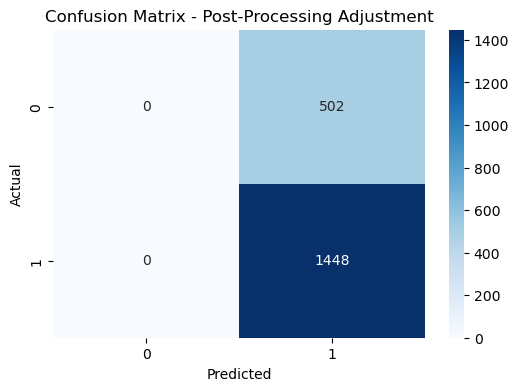

In [9]:
# Dummy function to adjust predictions post-training
def adjust_predictions(predictions):
    # Example: Ensure equal probability for both classes
    adjusted_predictions = predictions.copy()
    for i in range(len(predictions)):
        adjusted_predictions[i] = 1 - predictions[i] if predictions[i] < 0.5 else predictions[i]
    return adjusted_predictions

# Apply post-processing adjustment
adjusted_predictions = adjust_predictions(predictions_biased)
print("\nMetrics after Post-Processing Adjustment:")
print("Accuracy:", accuracy_score(actuals_biased, adjusted_predictions))
print("Precision:", precision_score(actuals_biased, adjusted_predictions))
print("Recall:", recall_score(actuals_biased, adjusted_predictions))
print("F1-score:", f1_score(actuals_biased, adjusted_predictions))
print(classification_report(actuals_biased, adjusted_predictions))

# Plotting confusion matrix after post-processing adjustment
conf_matrix_adjusted = confusion_matrix(actuals_biased, adjusted_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Post-Processing Adjustment')
plt.show()


### Step 6: Display Results Side-by-Side


In [12]:
# Compare results before and after bias mitigation
methods = ['Biased Model', 'Fairness Regularization', 'Adversarial Debiasing', 'Fair Representation', 'Post-Processing']
accuracies = [
    accuracy_score(actuals_biased, predictions_biased),
    accuracy_score(actuals_fair, predictions_fair),
    accuracy_score(actuals_adv, predictions_adv),
    accuracy_score(actuals_fair_rep, predictions_fair_rep),
    accuracy_score(actuals_biased, adjusted_predictions)
]
reports = [
    classification_report(actuals_biased, predictions_biased, output_dict=True),
    classification_report(actuals_fair, predictions_fair, output_dict=True),
    classification_report(actuals_adv, predictions_adv, output_dict=True),
    classification_report(actuals_fair_rep, predictions_fair_rep, output_dict=True),
    classification_report(actuals_biased, adjusted_predictions, output_dict=True)
]

# Plotting accuracy comparison
plt.figure(figsize=(12, 6))
plt.bar(methods, accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.title('Accuracy Comparison Before and After Bias Mitigation')
plt.show()

# Display classification reports for each method
for method, report in zip(methods, reports):
    print(f"\nClassification Report for {method}:\n")
    print(report)

# Additional plots or analysis can be added as needed


NameError: name 'actuals_fair_rep' is not defined